In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
#from xgboost import XGBClassifier

from sklearn.inspection import permutation_importance

from sklearn.metrics import recall_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingRegressor
from sklearn.impute import SimpleImputer

from mpl_toolkits import mplot3d

In [2]:
pd.set_option('display.max_columns', None)
X = pd.read_csv('../../../data/trainingsetvalues.csv')
y_full = pd.read_csv('../../../data/trainingsetlabels.csv')

In [3]:
X.funder = X.funder.replace(np.nan, 'Unknown')
X.installer = X.installer.replace(np.nan, 'Unknown')
X.permit = X.permit.replace(np.nan, False)

In [4]:
y_full = y_full.drop(columns = 'id')

In [5]:
y_full.status_group.loc[y_full.status_group == 'functional'] = 1
y_full.status_group.loc[y_full.status_group != 1] = 0
y_full = y_full.astype(int)

In [6]:
droplist = ['wpt_name', 'subvillage', 'num_private', 'scheme_name', 'recorded_by', 'scheme_management', 'management', 'extraction_type', 
            'payment', 'extraction_type_class', 'quality_group', 'quantity_group', 'source', 'source_class', 'waterpoint_type_group', 'ward',
           'region_code', 'district_code', 'public_meeting', 'funder', 'lga', 'management_group']

X_clean_full = X.drop(columns = droplist, axis=1)

# Filled in Zero's for the gps_height column

In [7]:
dodoma_idx = X_clean_full[X_clean_full.region == 'Dodoma'].index
X_clean_full.at[dodoma_idx, 'gps_height'] = 1350

In [8]:
kagera_idx = X_clean_full[X_clean_full.region == 'Kagera'].index
X_clean_full.at[kagera_idx, 'gps_height'] = 1450

In [9]:
mbeya_idx = X_clean_full[X_clean_full.region == 'Mbeya'].index
X_clean_full.at[mbeya_idx, 'gps_height'] = 1715

In [10]:
tabora_idx = X_clean_full[X_clean_full.region == 'Tabora'].index
X_clean_full.at[tabora_idx, 'gps_height'] = 1200

In [11]:
shinyanga_idx = X_clean_full[X_clean_full.region == 'Shinyanga'].index
X_clean_full.at[shinyanga_idx, 'gps_height'] = 1162

In [12]:
mwanza_idx = X_clean_full[X_clean_full.region == 'Mwanza'].index
X_clean_full.at[mwanza_idx, 'gps_height'] = 1200

# Created a new age column

In [13]:
years = [int(X_clean_full['date_recorded'][x][:4]) for x in range(len(X_clean_full['date_recorded']))]
X_clean_full['date_recorded'] = years

In [14]:
X_clean_full.construction_year = X_clean_full.construction_year.replace(0, 2000)

In [15]:
X_clean_full['age'] = X_clean_full['date_recorded'] - X_clean_full['construction_year']

# Cleaned up the Installer Column

In [16]:
top_installers = list(X_clean_full.installer.value_counts()[:7].index)
top_installers

['DWE', 'Unknown', 'Government', 'RWE', 'Commu', 'DANIDA', 'KKKT']

In [17]:
X_clean_full.installer.loc[~X_clean_full['installer'].isin(top_installers)] = 'Other'

C:\Users\rober\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


# TT Split

In [18]:
X_clean, X_test, y, y_test = train_test_split(X_clean_full, y_full, random_state=1)

# Made a function for returning catagorical and numerical columns

In [19]:
def cleaning(data):
    cat_cols = list(data.select_dtypes('object'))
    numeric_cols = list(data.select_dtypes('number'))
    cat_df = pd.DataFrame(data[cat_cols])
    numeric_df = pd.DataFrame(data[numeric_cols])
    return cat_df, numeric_df

# Split into categorical and numerical

In [20]:
X_cats, X_nums = cleaning(X_clean)
X_cats_test, X_nums_test = cleaning(X_test)
X_nums.drop(columns = ['longitude', 'latitude', 'id'], inplace=True)
X_nums_test.drop(columns = ['longitude', 'latitude', 'id'], inplace=True)

# One hot encoder and scaler

In [21]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(X_cats)
X_cats_ohe = pd.DataFrame(ohe.transform(X_cats), columns = ohe.get_feature_names(input_features = X_cats.columns))
X_cats_ohe_test = pd.DataFrame(ohe.transform(X_cats_test), columns = ohe.get_feature_names(input_features = X_cats_test.columns))

In [22]:
ss = StandardScaler()
ss.fit(X_nums)
X_nums_scaled = pd.DataFrame(ss.transform(X_nums), columns = X_nums.columns)
X_nums_scaled_test = pd.DataFrame(ss.transform(X_nums_test), columns = X_nums_test.columns)

In [23]:
X_data = pd.concat((X_nums_scaled, X_cats_ohe), axis=1)
X_data_test = pd.concat((X_nums_scaled_test, X_cats_ohe_test), axis=1)

# Our class for testing data features on our model

In [24]:
class Model:
    
    def __init__(self, model, y):
        self.model = model
        self.y = np.array(y).ravel()
        self.columns = ['f1 score', 'accuracy_score', 'Notes']
        self.df = pd.DataFrame(columns = self.columns)
        
    def model_history(self, X, notes, y_new=pd.DataFrame()):
        if y_new.empty==True:
            y_new = self.y
        
        f1_score_ = cross_val_score(self.model, X, cv=3, scoring = 'f1', y=y_new)
        accuracy_score_ = cross_val_score(self.model, X, cv=3, scoring='accuracy', y=y_new)
        frame = pd.DataFrame([[f1_score_.mean(), accuracy_score_.mean(), notes]], columns=self.columns)
        self.df = self.df.append(frame).reset_index(drop=True)
#       self.df = self.df.sort_values('f1 score', ascending=False)
        return self.df

    def error_vis(self, X, y_new=pd.DataFrame()):
        if y_new.empty==True:
            y_new = self.y
        self.model.fit(X, y_new)
        sns.set(rc = {'figure.figsize':(10,6)})
        sns.distplot((np.array(y_new).ravel() - self.model.predict_proba(X)[:,1]),
            color='blue', bins=25, kde_kws = {'color':'red'})

### Function for removing one hot encoded catagories from a DataFrame

In [25]:
def remove_column(col):
    remove_list = []
    for x in X_data.columns:
        if col in x:
            remove_list.append(x)
    X_data_new = X_data.drop(columns = remove_list)
    return X_data_new

# Our Model

In [26]:
rf_2 = RandomForestClassifier(max_depth = 18, min_samples_split = 15, n_estimators = 50, random_state = 1)

## Base Model with no engineering

In [27]:
tester = Model(rf_2, y)

In [28]:
tester.model_history(X_data, notes= 'Base model with standard feature engineering')

,f1 score,accuracy_score,Notes
0,0.82704,0.797262,Base model with standard feature engineering


## Testing the model with only data it guessed correctly

### (This was a total failure)

In [29]:
# def modeling_function(model, X_train, y_train, X_val, y_val):

#     # fit model on training data
#     y_train = np.array(y_train).ravel()
#     y_val = np.array(y_val).ravel()

#     model.fit(X_train, y_train)

#     # make predictions on training and validation data
#     train_preds = model.predict(X_train)
#     val_preds = model.predict(X_val)

#     # Print accuracy score
    
#     train_acc = accuracy_score(y_train, train_preds).round(3)
#     val_acc = accuracy_score(y_val, val_preds).round(3)
#     train_f1 = f1_score(y_train, train_preds).round(3)
#     val_f1 = f1_score(y_val, val_preds).round(3)
    
#     print('----------------------------------------------------')
#     print('Accuracy Score:')
#     print('Training score: ', accuracy_score(y_train, train_preds).round(3))
#     print('Validation score: ', accuracy_score(y_val, val_preds).round(3))
#     print('----------------------------------------------------')
    
#     print('----------------------------------------------------')
#     print('f1 Score:')
#     print('Training score: ', f1_score(y_train, train_preds).round(3))
#     print('Validation score: ', f1_score(y_val, val_preds).round(3))
#     print('----------------------------------------------------')

In [30]:
# X_train_err, X_test_err, y_train_err, y_test_err = train_test_split(X_data, y, random_state=1)

In [31]:
# error_df = pd.DataFrame()
# error_df = pd.concat((pd.DataFrame(np.array(y_train).ravel()), pd.DataFrame(rf_err.predict_proba(X_train))), axis=1)
# error_df.set_index(X_train_err.index, inplace=True)
# error_df['prediction'] = rf_err.predict(X_train_err)
# error_df.columns = ['True Value', 'P: Broke', 'P: Works', 'Prediction']

# error_df['Correct?'] = (error_df['Prediction'] == error_df['True Value'])
# error_df['Percent Wrong'] = np.array(y_train).ravel() - rf_err.predict_proba(X_train_err)[:,1]
# error_df['Percent Wrong'] = error_df['Percent Wrong'].map(abs)*100

# correct_error_df = error_df.loc[(error_df['Percent Wrong'] < 50)]
# incorrect_error_df = error_df.loc[(error_df['Percent Wrong'] >= 50)]

# correct_indexes = correct_error_df.index
# incorrect_indexes = incorrect_error_df.index

# correct_X = X_train_err.drop(index=incorrect_indexes)
# correct_y = y_train.drop(index=incorrect_indexes)

# incorrect_X = X_train_err.drop(index=correct_indexes)
# incorrect_y = y_train.drop(index=correct_indexes)


In [32]:
# poop = RandomForestClassifier(max_depth = 16, min_samples_split = 2, n_estimators = 100, random_state = 1)

In [33]:
# modeling_function(poop, correct_X, correct_y, X_test, y_test)

In [34]:
# modeling_function(poop, correct_X, correct_y, incorrect_X, incorrect_y)

## Dropping Construction Year and Date Recorded

In [35]:
X_data_1 = X_data.drop(columns = ['date_recorded', 'construction_year'])

In [36]:
tester.model_history(X_data_1, notes='Removed Date Recorded and Construction Year')

,f1 score,accuracy_score,Notes
0,0.827040,0.797262,Base model with standard feature engineering
1,0.826764,0.796431,Removed Date Recorded and Construction Year


## Dropping just Construction Year

In [37]:
X_data_2 = X_data.drop(columns = 'construction_year')

In [38]:
tester.model_history(X_data_2, notes='Removed Construction Year')

,f1 score,accuracy_score,Notes
0,0.827040,0.797262,Base model with standard feature engineering
1,0.826764,0.796431,Removed Date Recorded and Construction Year
2,0.826684,0.795578,Removed Construction Year


C:\Users\rober\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


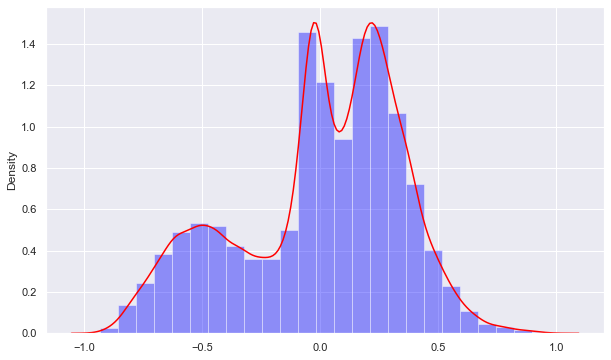

In [39]:
tester.error_vis(X_data_2)

## Dropping Basin Data

In [40]:
X_data_3 = remove_column('basin')

In [41]:
tester.model_history(X_data_3, notes='Removed basin column')

,f1 score,accuracy_score,Notes
0,0.827040,0.797262,Base model with standard feature engineering
1,0.826764,0.796431,Removed Date Recorded and Construction Year
2,0.826684,0.795578,Removed Construction Year
3,0.826273,0.795735,Removed basin column


C:\Users\rober\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


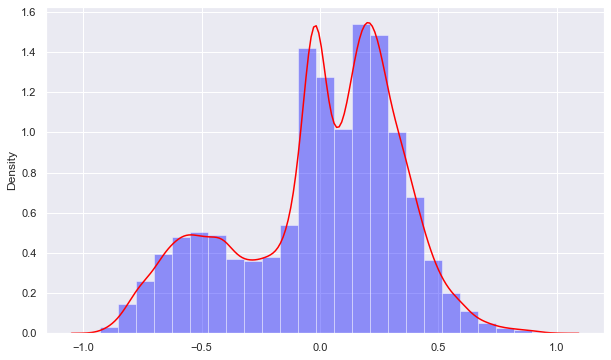

In [42]:
tester.error_vis(X_data_3)

## Being more specific with extraction type

In [43]:
X_data_4_raw = X_data.copy()
X_data_4_col = X[['extraction_type']].iloc[X_data.index]

In [44]:
ohe2 = OneHotEncoder(sparse=False)
ohe2.fit(X_data_4_col)
X_data_4_ohe = pd.DataFrame(ohe2.transform(X_data_4_col), columns = ohe2.get_feature_names(input_features = X_data_4_col.columns))
X_data_4_old = pd.concat((X_data_4_raw.reset_index(), X_data_4_ohe.reset_index()), axis=1)

In [45]:
ex_group_remove_list = []
for x in X_data_4_old.columns:
    if 'extraction_type_group_' in x:
        ex_group_remove_list.append(x)
X_data_4 = X_data_4_old.drop(columns = ex_group_remove_list)

In [ ]:
tester.model_history(X_data_4, notes='Replaced Extraction Group with Extraction Type')

## Dropping the first row of each encoded variable

In [ ]:
ohe3 = OneHotEncoder(sparse=False, drop='first')
ohe3.fit(X_cats)
X_5_cats_ohe = pd.DataFrame(ohe3.transform(X_cats), columns = ohe3.get_feature_names(input_features = X_cats.columns))

In [ ]:
X_data_5 = pd.concat((X_nums_scaled, X_5_cats_ohe), axis=1)

In [ ]:
tester.model_history(X_data_5, notes = "Dropped first columns for OHE'd features")

## Dropping Age

In [ ]:
X_data_6 = X_data.drop(columns = 'age')

In [ ]:
tester.model_history(X_data_6, notes = 'Dropped Age')

# Using Feature Permutation

## Dropping All Columns with an error under 0.01 (80 cols)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y, random_state=1)

In [ ]:
y_train = np.array(y_train).ravel()

In [ ]:
rf_2.fit(X_train, y_train)

In [ ]:
perm_result = permutation_importance(rf_2, X_train, y_train, n_repeats=1, random_state=1)

In [ ]:
f_importance = sorted(list(zip(X_train.columns, perm_result.importances.ravel())), key=lambda x: x[1])
x_ax = [_[0] for _ in f_importance]
y_ax = [_[1] for _ in f_importance]

plt.figure(figsize=(15,6))
plt.bar(x_ax, y_ax)
plt.xticks(rotation=90);

In [ ]:
f_imp_df = pd.DataFrame(f_importance)

In [ ]:
perm_droplist = list(f_imp_df.loc[f_imp_df[1]<0.01][0])

In [ ]:
X_data_7 = X_data.drop(columns = perm_droplist, axis=1)

In [ ]:
tester.model_history(X_data_7, notes='Dropped 80 columns with Feature Permutation')

## Dropping All Negative Error

In [ ]:
perm_droplist_2 = list(f_imp_df.loc[f_imp_df[1]<0][0])

In [ ]:
X_data_8 = X_data.drop(columns = perm_droplist_2, axis=1)

In [ ]:
tester.model_history(X_data_8, notes='Dropped Negative Error cols w/ FP')

## Dropping all columns with a FP score under 0.001

In [ ]:
perm_droplist_3 = list(f_imp_df.loc[f_imp_df[1]<0.001][0])

In [ ]:
X_data_9 = X_data.drop(columns = perm_droplist_2, axis=1)

In [ ]:
tester.model_history(X_data_9, notes = 'Dropped all columns with a FP score under 0.001')

## SMOTE-ing in more data

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE(random_state=1)
X_data_10, y_data_10 = smote.fit_sample(X_data, y)

In [ ]:
tester.model_history(X=X_data_10, y_new=y_data_10, notes= 'SMOTE-ed in more dummy data')